# The trapezoidal rule for numerical integration

**Illustrates**: basic array slicing, functions as first class objects.

In this exercise, you are tasked with implementing the simple trapezoid
rule formula for numerical integration that we illustrated above.


If we denote by $x_{i}$ ($i=0,\ldots,n,$ with $x_{0}=a$ and $x_{n}=b$) the abscissas
where the function is sampled, then

$$\int_{a}^{b}f(x)dx\approx\frac{1}{2}\sum_{i=1}^{n}\left(x_{i}-x_{i-1}\right)\left(f(x_{i})+f(x_{i-1})\right).$$

The common case of using equally spaced abscissas with spacing $h=(b-a)/n$ reads:

$$\int_{a}^{b}f(x)dx\approx\frac{h}{2}\sum_{i=1}^{n}\left(f(x_{i})+f(x_{i-1})\right).$$

One frequently receives the function values already precomputed, $y_{i}=f(x_{i}),$ so the formula becomes

$$\int_{a}^{b}f(x)dx\approx\frac{1}{2}\sum_{i=1}^{n}\left(x_{i}-x_{i-1}\right)\left(y_{i}+y_{i-1}\right).$$

In this exercise, you'll need to write two functions, `trapz` and `trapzf`. `trapz` applies the trapezoid formula to pre-computed values, implementing equation trapz, while `trapzf` takes a function $f$ as input, as well as the total number of samples to evaluate, and computes the equation above.

Test it and show that it produces correct values for some simple integrals you can compute analytically or compare your answers against `scipy.integrate.trapz`, using as test function $f(x)$:

$$
f(x) = (x-3)(x-5)(x-7)+85
$$

integrated between $a=1$ and $b=9$.


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy.integrate as sint

In [2]:
def f(x):
    return (x-3)*(x-5)*(x-7)+85

a, b, n = (1, 9, 200)
x = np.linspace(a, b, n)
y = f(x)

print("Reference:")
print(sint.trapz(y, x))

Reference:
680.0


In [3]:
def trapz(y, x):
    return 0.5*((x[1:]-x[:-1])*(y[1:]+y[:-1])).sum()

def trapzf(f, a, b, n):
    x = np.linspace(a, b, n)
    # Sample the input function at all values of x
    y = f(x)
    # Note that in the equations above, the list had n+1 points. Since here we're using
    # n as the total number of points, the actual size of the interval h should 
    # use n-1 in the formula:
    h = (b-a)/(n-1)
    # Compute the trapezoid rule sum for the final result
    return (h/2)*(y[1:]+y[:-1]).sum()

print("Our functions")
print(trapz(y, x))
print(trapzf(f, a, b, n))

Our functions
680.0
680.0


## Some performance notes

Let's compare the time it takes to compute the fully vectorized form in our `trapz` with a more manual implementation that does the computation with a pure Python loop.

In [4]:
def trapzl(y, x):
    s = 0
    for i in range(1, len(x)):
        s += (x[i]-x[i-1])*(y[i]+y[i-1])
    return s/2

trapzl(y, x)

680.00000000000011

Let's compute this over a much finer grid to really see the performance difference

In [5]:
a, b, n = (1, 9, 20_000)
x = np.linspace(a, b, n)
y = f(x)

tv = %timeit -o trapz(y, x)
tl = %timeit -o trapzl(y, x)

37 µs ± 1.32 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
10.8 ms ± 67.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [6]:
tl.average/tv.average

292.8693269399393

Let's see what the performance difference is across a range of sizes (note this will take a while to run):

In [7]:
a, b = 1, 9

tv, tl = [], []
sizes = np.logspace(1, 7, 7)
for n in sizes:
    x = np.linspace(a, b, int(n))
    y = f(x)
    t1 = %timeit -o trapz(y, x)
    tv.append(t1.average)
    t2 = %timeit -o trapzl(y, x)
    tl.append(t2.average)

tva = np.array(tv)
tla = np.array(tl)

3.56 µs ± 90.1 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
5.5 µs ± 73.9 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
3.58 µs ± 58.6 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
52.8 µs ± 908 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
5.92 µs ± 145 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
535 µs ± 7.29 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
18.6 µs ± 229 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
5.39 ms ± 121 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
152 µs ± 3.2 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
53.8 ms ± 1.82 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
3.46 ms ± 88.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
537 ms ± 6.31 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
70.7 ms ± 414 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
5.34 s ± 69 ms per loop (mean ± std. dev. of 7 runs, 1 loop

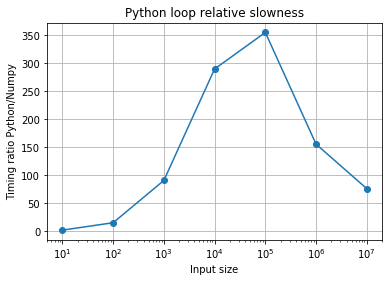

In [8]:
plt.semilogx(sizes, tla/tva, 'o-')
plt.grid(True)
plt.xlabel("Input size")
plt.ylabel("Timing ratio Python/Numpy")
plt.title("Python loop relative slowness");

A few observations:

- At very small sizes the difference isn't very dramatic. The overhead of the Python function call and basic arithmetic dominates.

- For input sizes ranging from the thousands to the million elements, the vectorized version can be ~ 100x to ~300x fastr than the pure Python loop.  This is not uncommon in real-world applications.

- At very large sizes (at a million) the performance profile changes.

In general it's extremely hard to predict exact performance ratios, which often vary in hard to understand ways with problem size, as hardware, cache and algorithm specifics intersect.  But the results of this example aren't suprising: whether exactly 100x or 350x slower, the fact remains that the vectorized solution vastly outperforms a pure Python loop.  This is a key aspect of Numpy as a key piece of high-performance Python.

For an in-depth look at the "vectorized mindset" for Numpy, Nicolas Rougier has written the excellent (and free!) book ["From Python to Numpy"](http://www.labri.fr/perso/nrougier/from-python-to-numpy).

## Numba

Let's have a look at how [Numba](https://numba.pydata.org) can help in this type of loop-intensive code.

In [9]:
from numba import jit

trapzn = jit(trapzl)

a, b, n = (1, 9, 200)
x = np.linspace(a, b, n)
y = f(x)

trapzn(y, x)

680.0000000000001

In [10]:
a, b, n = (1, 9, 20_000)
x = np.linspace(a, b, n)
y = f(x)

tv = %timeit -o trapz(y, x)
tn = %timeit -o trapzn(y, x)

36.6 µs ± 516 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
23.5 µs ± 508 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


That's pretty impressive! By simply *compiling* our slow, Python code, we get it to beat the Numpy version at a size of 200.

Let's collect Numba performance numbers similarly to the code above, and make a plot comparing Numba to Numpy at the same sizes:

In [11]:
a, b = 1, 9

tn = []
for n in sizes:
    x = np.linspace(a, b, int(n))
    y = f(x)
    t1 = %timeit -o trapzn(y, x)
    tn.append(t1.average)

tna = np.array(tn)

434 ns ± 9.27 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)
537 ns ± 10.6 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)
1.61 µs ± 15 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)
11.9 µs ± 122 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
114 µs ± 1.86 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
1.2 ms ± 9.35 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
13 ms ± 133 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Let's look at the Numba data alongside the Python one:

In [12]:
plt.loglog(sizes, tla/tva, 'o-', label="Python")
plt.loglog(sizes, tna/tva, 'o-', label="Numba")
plt.grid(True)
plt.legend()
plt.xlabel("Input size")
plt.ylabel("Timing ratios")
plt.title("Performance relative to vectorized Numpy");

Let's quickly see the Numba/Numpy ratios (the raw numbers):

In [13]:
print(tna/tva)
print(tva/tna)  # Let's look at the reverse relation, which may be a bit easier to interpret

[ 0.1220925   0.14990992  0.2724308   0.63829727  0.75062583  0.34658816
  0.18327677]
[ 8.19051152  6.67067248  3.67065689  1.56666814  1.33222167  2.88526879
  5.45622877]


Some quick thoughts:

- The Numba performance is *always* better than Numpy.  Note that this is a pretty ideal case for Numpy, and we did exactly *nothing* to the Python code other than compile it with `numba.jit`.  We're basically getting better-than-numpy performance for free.  Nubma can be a bit like magic ([this blog post](https://jakevdp.github.io/blog/2015/02/24/optimizing-python-with-numpy-and-numba/) by Jake VanderPlas contains much more detail).

- In some cases, the difference is quite remarkable. On the other hand, where Numpy performs best comapred to raw Python, Numba still beats it but not by too much.  This probably indicates Numpy is already nearly optimal in that range.


Let's look at the actual times instead, which in this case can be informative:

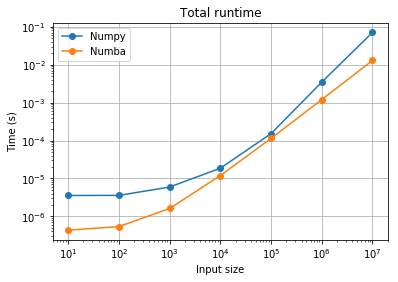

In [14]:
plt.loglog(sizes, tva, 'o-', label="Numpy")
plt.loglog(sizes, tna, 'o-', label="Numba")
plt.legend()
plt.grid(True)
plt.xlabel("Input size")
plt.ylabel("Time (s)")
plt.title("Total runtime");

We see that the runtime profile is more smoothly linear (as it should be) for the Numba code.

### Numerical accuracy

We should finally take a quick look at accuracy considerations. In this case we know the exact answer (680), so we can see how each method compares. As $n \rightarrow \infty$ we expect them all to converge to 680, but let's see if any of them accumulates error worse than the others.  Remember, since the Numba version is algorithmically nothing but the Python code, any differences between Python and Numba would be due to Numba's compilation/optimizations:

In [15]:
def err(val, exact=680):
    return abs((val-exact)/exact)

# This time, let's make empty arrays and fill them in
epy = np.empty_like(sizes)
enpy = np.empty_like(sizes)
enba = np.empty_like(sizes)

for i,n in enumerate(sizes):
    x = np.linspace(a, b, int(n))
    y = f(x)
    epy[i] = err(trapzl(y, x))
    enpy[i] = err(trapz(y, x))
    enba[i] = err(trapzn(y, x))

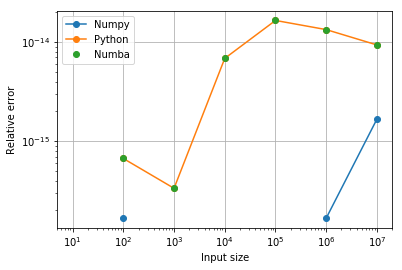

In [16]:
plt.loglog(sizes, enpy, 'o-', label='Numpy')
plt.loglog(sizes, epy, 'o-', label='Python')
plt.loglog(sizes, enba, 'o', label='Numba')
plt.legend()
plt.grid()
plt.xlabel("Input size")
plt.ylabel("Relative error");

Fortunately, we see that Numba produces identical results to Pure Python (good news: its optimizations don't change the results).  Furthermore, while we see a small loss of accuracy relative to Numpy's [high accuracy summation algorithm](https://github.com/numpy/numpy/pull/3685), the error is $\cal{O}(10^{-14})$, which is still close to floating-point precision.